# Notebook 3 - Inverse design: molecules on specification

By Vincent Blay, November 2021

In this notebook we demonstrate two approaches to the generation of new molecules with a desired property specification by leveraging MACAW embeddings. 

In the first approach we generate a single large library throughout the MACAW embedding space and then retrieve promising molecules using the `hit_finder` functions.

In the second approach we generate a series of small libraries using an evolutionary strategy using the `directed_molecular_evolution` function.

In both cases, the user is returned a list of promising SMILES molecules and their predicted property values.

In [31]:
pwd

'C:\\Users\\Enka\\Desktop\\LDRD\\macaw_repo\\notebooks'

In [32]:
import numpy as np
import pandas as pd
import pickle

#Needed to show molecules
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole 

import macaw
print(macaw.__version__)

from macaw import *

0.1.12


In [33]:
np.random.seed(123)

In this example we will use the RON dataset, so let us load it

In [34]:
df = pd.read_csv('../data/data_RON.csv')
smiles = df.Smiles
Y = df.RON

We will also use the RON property model, so let us load it. In this case we are generating new molecules, so we will not split the dataset

In [35]:
file = open('../results/RON_model_RVR.pickle', 'rb') 
mcw, regr = pickle.load(file)
file.close()

In [36]:
len(smiles)

194

In [37]:
mcw.transform(list(smiles))

array([[ 0.42037285,  0.06961411,  0.0838933 , ..., -0.0442504 ,
        -0.02479778, -0.00986333],
       [ 0.04410784,  0.01107567,  0.24158394, ...,  0.07641157,
         0.00242411,  0.03510653],
       [-0.07433707,  0.23414213, -0.00207759, ...,  0.03633542,
         0.20821371,  0.01867818],
       ...,
       [ 0.20423117, -0.05955342, -0.08059721, ...,  0.00245891,
        -0.08204407,  0.03756517],
       [ 0.30909945,  0.23170672,  0.15254119, ...,  0.21982397,
         0.0428042 , -0.15638203],
       [ 0.34420088,  0.26039054,  0.2446837 , ...,  0.17066445,
         0.04486746, -0.13455727]])

In [38]:
X = mcw.transform(smiles)

print(np.corrcoef(Y,regr.predict(X))[0,1])

0.9777705770632938


##  Approach 1. Molecular design by generating and screening a single large library

The library generation involves computing a noisy probability matrix from which  molecules will be drawn. Molecules will have a length of up to 20 SELFIES characters. We only consider robust SELFIES characters (i.e., those for which there are state-dependent derivation rules implemented).

In [39]:
smiles_lib = library_maker(smiles, max_len=20, n_gen=200000, algorithm='position', noise_factor=0.5)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
91447 unique molecules generated.


We first embed the library molecules in the MACAW space:

In [40]:
len(smiles_lib)

91447

In [41]:
X_lib = mcw.transform(smiles_lib)

In [42]:
X_lib.shape

(91447, 15)

And then we find promising molecular designs according to the desired specification (in this example, RON=110). 

For retrieving molecules from the 20-dimensional MACAW space, we will use our custom V-distance metric (`p=0.5`). If not specified, it will use `p=1` by default (Manhattan distance).

In [43]:
spec = 110. # desired RON design specification

idx, Y_hits_pred = hit_finder(X_lib, model= regr, spec = spec, X=X, Y=Y, n_hits=5, k1=5, k2=10, p=0.5, n_rounds=2)
smiles_hits = [smiles_lib[i] for i in idx]

print(smiles_hits)
print(Y_hits_pred)

['CCOP', 'CCOC(=O)C(C)C', 'CCC(C)C(=O)OC', 'CCC(C)C(C)(C)C', 'CCCc1ccccc1']
[106.74297284 106.82202083 107.59872636 107.68389061 110.29798894]


Let us visualize the molecules:

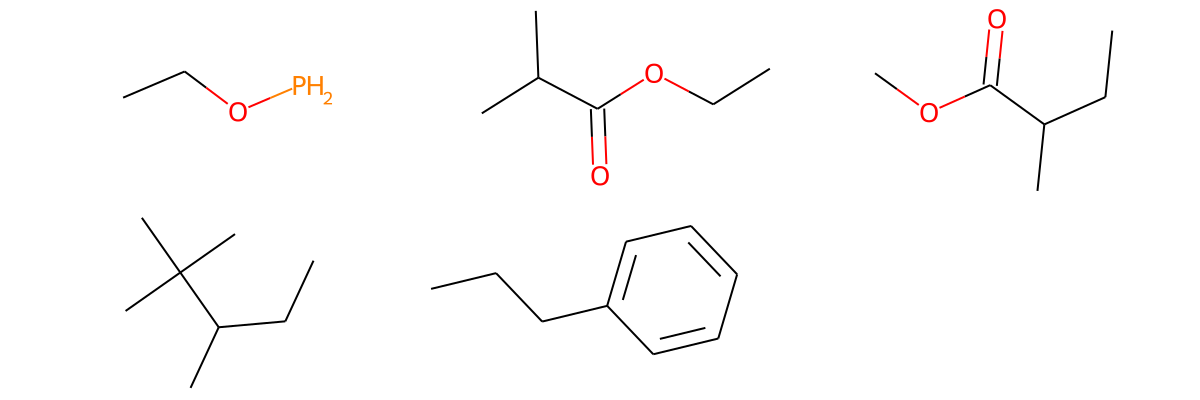

In [48]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits[:50]]

Draw.MolsToGridImage(molecules, subImgSize=(400,200))

We can double check that we get the desired property specification for the molecules designed:

In [49]:
X_hits = mcw.transform(smiles_hits)
Y_hits_pred2 = regr.predict(X_hits)
print(Y_hits_pred2)

[106.74297284 106.82202083 107.59872636 107.68389061 110.29798894]


Since MACAW embeddings are smooth, we can also use a gradient-based method to navigate the embedding space and retrieve promising molecules. To this end, we use the function `hit_finder2`. If we do not provide the arguments `X` or `Y`, we may want to increase the parameter `k1`.

In [50]:
idx2, Y_hits_pred2 = hit_finder2(X_lib, regr, spec, X=X, n_hits=5, k1=100, k2=5)
smiles_hits2 = [smiles_lib[i] for i in idx2]
print(smiles_hits2)
print(Y_hits_pred2)

['CC=C1C=C1C=CC=O', 'C=CC(C)(C)P', 'CC1=C(C)C=C=C1', 'CC12CC1C2(C)PO', 'Cc1ccoc1C']
[109.88524083 109.98977125 110.08642992 110.14558693 110.14691115]


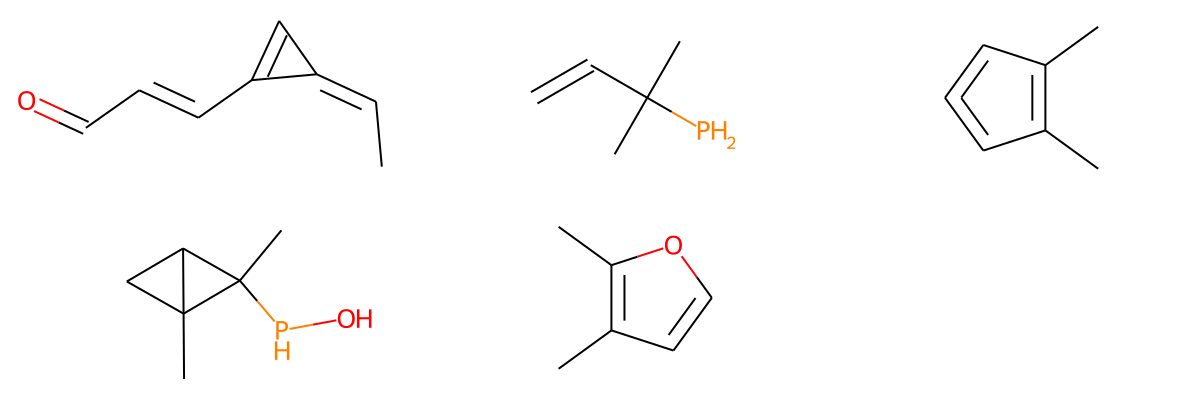

In [51]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits2[:50]]

Draw.MolsToGridImage(molecules, subImgSize=(400,200))

## Approach 2. Molecular design by evolving multiple focused molecular libraries

Let us use MACAW's library evolver to generate molecules with a predicted RON specification of 40. 

By default, `library_evolver` will evolve 8 generations of molecules. This number can be controlled using the optional argument `N_rounds`. With the optional argument `N_hits` we specify the number of molecules that we want the algorithm to return in its output.

In [52]:
%%capture
smiles_hits3, Y_hits_pred3 = library_evolver(smiles, mcw, regr, spec=40, n_hits=5, n_rounds=8)

In [53]:
print(smiles_hits3)
print(Y_hits_pred3)

['CCCC1CCCC(P=P)C1', 'CCCCCC(CCP(C)C)P=P', 'CCCCC(C)CC=O', 'CCCC1PCCCCC1O', 'CPCC(C)CCCPO']
[39.92771879 39.95302005 40.02650731 40.03251777 40.04060939]


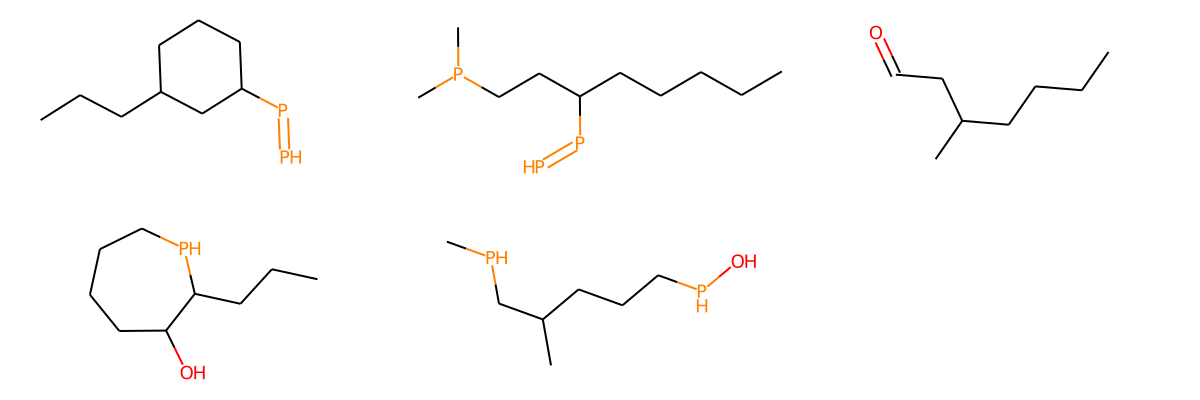

In [54]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits3[:50]]

Draw.MolsToGridImage(molecules, subImgSize=(400,200))

Since we are working with a RVR model, we can also estimate the prediction errors:

In [55]:
X = mcw.transform(smiles_hits3)
Y_hits_pred3, Y_hits_pred3_std = regr.predict(X, return_std=True)

In [56]:
print(smiles_hits3)
print(Y_hits_pred3)
print(Y_hits_pred3_std)

['CCCC1CCCC(P=P)C1', 'CCCCCC(CCP(C)C)P=P', 'CCCCC(C)CC=O', 'CCCC1PCCCCC1O', 'CPCC(C)CCCPO']
[39.92771879 39.95302005 40.02650731 40.03251777 40.04060939]
[5.11324002 4.8670474  4.77589774 5.25667646 4.91746051]


Let us now try to design molecules with a RON design specification of 80:

In [57]:
%%capture
smiles_hits3, Y_hits_pred3 = library_evolver(smiles, mcw, regr, spec=80, n_hits=5)

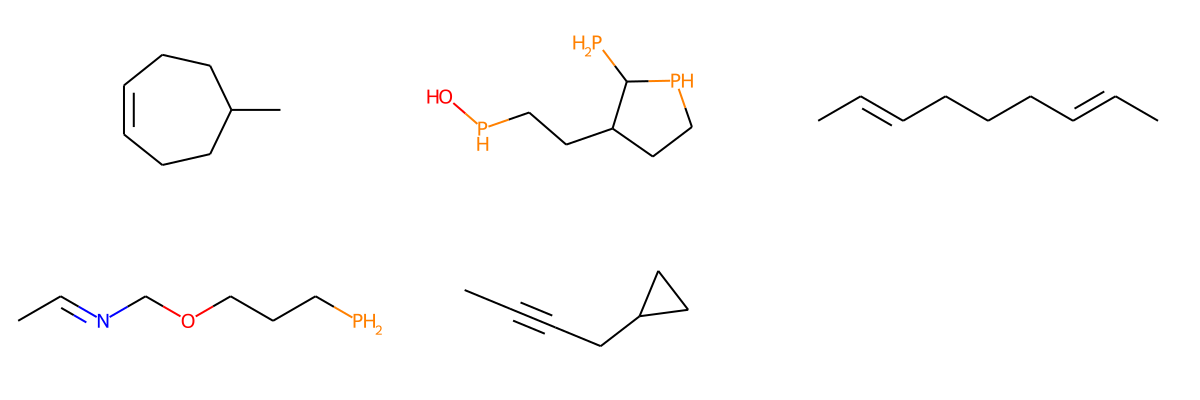

In [58]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits3[:50]]

Draw.MolsToGridImage(molecules, subImgSize=(400,200))

In [59]:
X = mcw.transform(smiles_hits3)
Y_hits_pred3, Y_hits_pred3_std = regr.predict(X, return_std=True)

In [60]:
print(smiles_hits3)
print(Y_hits_pred3)
print(Y_hits_pred3_std)

['CC1CCC=CCC1', 'OPCCC1CCPC1P', 'CC=CCCCC=CC', 'CC=NCOCCCP', 'CC#CCC1CC1']
[79.9872768  79.99361145 79.99698761 80.00838834 80.01348568]
[4.60271119 4.83890377 4.70374604 5.10003733 4.83339928]


Let us now try to design molecules with a RON specification of 120:

In [61]:
%%capture
smiles_hits3, Y_hits_pred3 = library_evolver(smiles, mcw, regr, spec=120, n_hits=5)

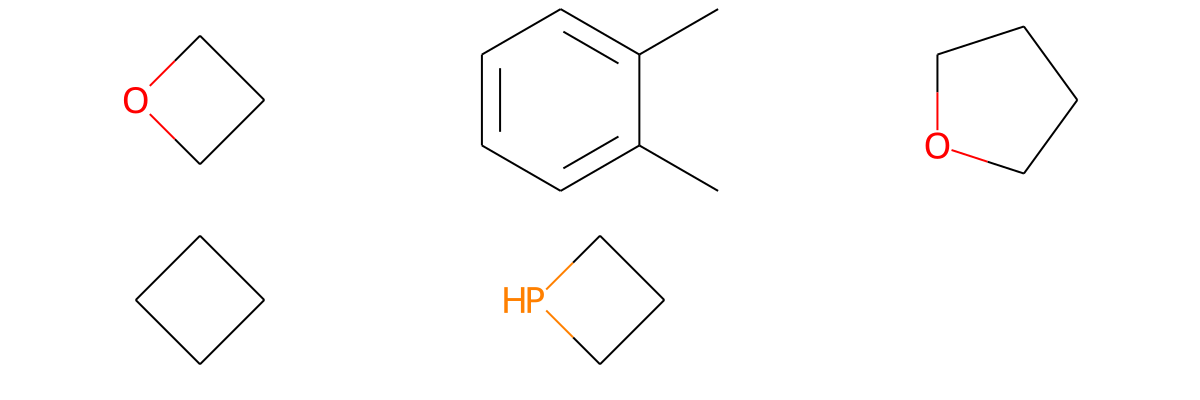

In [62]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits3[:50]]

Draw.MolsToGridImage(molecules, subImgSize=(400,200))

In [63]:
X = mcw.transform(smiles_hits3)
Y_hits_pred3, Y_hits_pred3_std = regr.predict(X, return_std=True)

In [64]:
print(smiles_hits3)
print(Y_hits_pred3)
print(Y_hits_pred3_std)

['C1COC1', 'CC1=CC=CC=C1C', 'C1CCOC1', 'C1CCC1', 'C1CPC1']
[116.76669887 120.75130685 121.26563649 122.38757089 123.41295932]
[5.93872569 6.00204726 6.51395099 7.44988898 6.90550283]


### Multi-objective optimization in molecular recommendation

We can also encourage the recommendation of molecules whose property value is predicted with higher confidence. To this end, we define a custome objective function `f`, which consists of a weighted sum of the offset from the desired specification (in this case RON = 40.) and the prediction error, and we ask the `library_evolver` to make it zero.

In [129]:
def f(X):
    Y_pred, Y_pred_std = regr.predict(X, return_std=True)
    FO = np.abs(Y_pred - 120.) + 1.*(Y_pred_std)
    
    return FO

In [130]:
%%capture
smiles_hits3, Y_hits_pred3 = library_evolver(smiles, mcw, f, spec=0., n_hits=5, n_rounds=8)

In [131]:
X = mcw.transform(smiles_hits3)
Y_hits_pred3, Y_hits_pred3_std = regr.predict(X, return_std=True)

In [132]:
print(smiles_hits3)
print(Y_hits_pred3)
print(Y_hits_pred3_std)

['CC1=CC=CC=C1C', 'C1CCOC1', 'C1COC1', 'CCOC(=O)CC', 'CCOC(C)=O']
[120.75130685 121.26563649 116.76669887 115.4999918  116.47693969]
[6.00204726 6.51395099 5.93872569 4.74786732 6.00316563]


The point estimates for the RON of these molecules are not as close to the desired specification as in the design example above, but the prediction errors are now smaller.

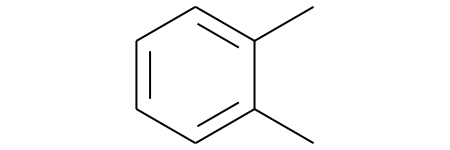

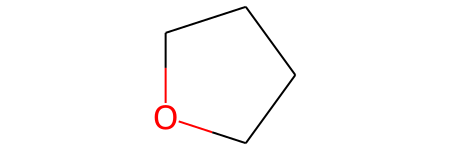

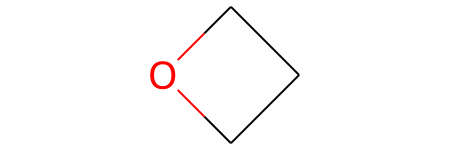

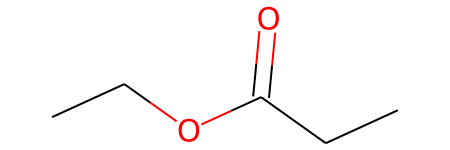

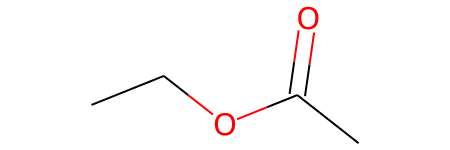

In [133]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

for smi in smiles_hits3:
    MolFromSmiles(smi)